band_width: 0.9765625
lambda: 0.000476837158203125
error: 0.332357664590272


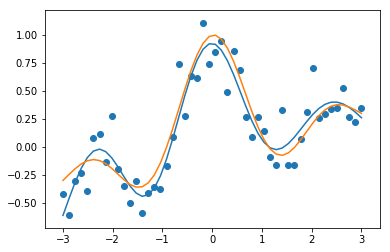

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


class GaussianKernelModel:
    def __init__(self, b_width, lam):
        self.b_width = b_width
        self.theta = 0
        self.lam = lam
        self.train_x = []

    def fit(self, X, Y):
        self.train_x = X
        K = np.array([self._gaussian_kernel(X[i], X) for i in range(len(X))])
        self.theta = self._calc_theta(K, Y)

    def predict(self, x):
        return np.array([self.theta.dot(self._gaussian_kernel(x[i], self.train_x)) for i in range(len(x))])

    def _gaussian_kernel(self, xi, xj):
        return np.exp(-((xi - xj) ** 2) / (2 * (self.b_width ** 2)))

    def _calc_theta(self, K, Y):
        dotk = K.dot(K)
        ones = self.lam * np.eye(len(self.train_x))
        plused = dotk + ones
        invs = np.linalg.inv(plused)
        return invs.dot(K).dot(Y)


def create_data(n, random=False):
    x = np.linspace(-3, 3, n)
    if random:
        np.random.shuffle(x)
    y = np.sin(np.pi * x) / (np.pi * x) + 0.1 * x + np.random.normal(0, 0.2, n)
    return x, y


def cross_validation(estimator, X, Y, split_num):
    error_all = 0
    X_split = np.array(np.split(X, split_num))
    Y_split = np.array(np.split(Y, split_num))
    for i in range(split_num):
        idx_use = np.ones(split_num, dtype=bool)
        idx_use[i] = False
        train_x = np.hstack(X_split[idx_use])
        train_y = np.hstack(Y_split[idx_use])
        test_x = X_split[i]
        test_y = Y_split[i]
        estimator.fit(train_x, train_y)
        prediction = estimator.predict(test_x)
        error_all += np.sum((test_y - prediction) ** 2)
    return error_all / split_num


def do_cross_validation(X, Y, split_num, time):
    p_h = 1000
    h_min = p_h
    err_min = 1000000
    p_lambda = 1000
    for i in range(time):
        gaussian_kernel = GaussianKernelModel(p_h, p_lambda)
        err_h = cross_validation(gaussian_kernel, X, Y, split_num)
        p_h *= 0.5
        if err_h < err_min:
            h_min = p_h
            err_min = err_h
    p_h = h_min

    err_min = 1000000
    lam_min = p_lambda
    for i in range(time):
        gaussian_kernel = GaussianKernelModel(p_h, p_lambda)
        err_l = cross_validation(gaussian_kernel, X, Y, split_num)
        p_lambda *= 0.5
        if err_l < err_min:
            lam_min = p_lambda
            err_min = err_l
    return h_min, lam_min, err_min


if __name__ == '__main__':
    n = 50
    X, Y = create_data(n, True)

    h_min, lam_min, err_min = do_cross_validation(X, Y, 5, 100)
    print(f'band_width: {h_min}')
    print(f'lambda: {lam_min}')
    print(f'error: {err_min}')
    gaussian_kernel = GaussianKernelModel(h_min, lam_min)
    X, Y = create_data(n)
    gaussian_kernel.fit(X, Y)
    ans = gaussian_kernel.predict(X)
    plt.plot(X, ans)

    # correct data
    plt.scatter(X, Y)
    plt.plot(X, np.sin(np.pi * X) / (np.pi * X) + 0.1 * X)
